<a href="https://colab.research.google.com/github/chengren/bky_hw_lab/blob/edu/Re_do.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2> Xiaoyou Li/Zhi Li/Cheng Ren<br>
<h4> Lab: Visualizing representations of problems and skills using word2vec (extra credit re-do)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#import dependency
import pandas as pd
import numpy as np
import gensim
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
plt.rcParams['agg.path.chunksize'] = 10000

1.Use your choice of a dataset or sample of a dataset from lab 1. Apply the skip-gram model to sequences of problem answering (vector size, window size - a min count of 10 is recommended and iter of 30). To be clear, the sequences should consist of some ID unique to the problem, question, or step being answered by the student. You may want to choose to filter out responses that are not associated with a skill in your dataset.

In [0]:
!pwd
df = pd.read_csv('/content/drive/My Drive/Copy of 2012-2013-data-with-predictions-4-final.csv', encoding='ISO-8859-1')

/content


In [0]:
df = df.sort_values(by=['user_id','problem_log_id'])
df = df.dropna(subset=['skill'])

In [0]:
df.head()

,problem_log_id,skill,problem_id,user_id,assignment_id,assistment_id,start_time,end_time,problem_type,original,correct,bottom_hint,hint_count,actions,attempt_count,ms_first_response,tutor_mode,sequence_id,student_class_id,position,type,base_sequence_id,skill_id,teacher_id,school_id,overlap_time,template_id,answer_id,answer_text,first_action,problemlogid,Average_confidence(FRUSTRATED),Average_confidence(CONFUSED),Average_confidence(CONCENTRATING),Average_confidence(BORED)
968401,145035021,Equation Solving Two or Fewer Steps,694349,21421,807354,439703,2013-05-22 14:44:20,2013-05-22 14:44:43.483,algebra,1,0.0,1.0,2,"--- \n- - start\n - 1369248260345\n - ""17465...",1,17482,tutor,195693,26029,1,LinearSection,195693,311.0,11436,4986.0,17482,439703,NaN,NaN,1,145035021,0.361323,0.0,0.766925,0.218182
3276993,145281682,Point Plotting,114117,21421,816118,59886,2013-06-05 13:00:06,2013-06-05 13:00:13.897,choose_1,1,1.0,0.0,0,"--- \n- - start\n - 1370451606060\n - ""11535...",1,7890,tutor,7922,26029,5,MasterySection,7922,103.0,11436,4986.0,7890,58277,NaN,Quadrant IV,0,145281682,0.361323,0.0,0.336529,0.442968
4305094,145281685,Point Plotting,114088,21421,816118,59857,2013-06-05 13:00:14,2013-06-05 13:00:21.642,choose_1,1,1.0,0.0,0,"--- \n- - start\n - 1370451614808\n - ""11532...",1,7634,tutor,7922,26029,5,MasterySection,7922,103.0,11436,4986.0,7634,56528,NaN,Quadrant IV,0,145281685,0.361323,0.0,0.766925,0.000000
3515970,145281693,Point Plotting,114082,21421,816118,59851,2013-06-05 13:00:22,2013-06-05 13:00:28.316,choose_1,1,1.0,0.0,0,"--- \n- - start\n - 1370451622765\n - ""11532...",1,6309,tutor,7922,26029,5,MasterySection,7922,103.0,11436,4986.0,6309,56528,NaN,Quadrant II,0,145281693,0.361323,0.0,0.766925,0.000000
2416143,145281697,Addition and Subtraction Integers,665276,21421,816117,419204,2013-06-05 13:00:39,2013-06-05 13:00:44.274,algebra,1,1.0,0.0,0,"--- \n- - start\n - 1370451639389\n - ""15872...",1,5256,tutor,7160,26029,4,MasterySection,7014,277.0,11436,4986.0,5256,29951,NaN,-8,0,145281697,0.361323,0.0,0.336529,0.442968


In [0]:
df.shape

(2630080, 35)

In [0]:
len(df.problem_id.unique())

50988

In [0]:
problem_skill = df[['problem_id','skill']]
problem_skill.columns = ['id','skill']
problem_skill['id'] = problem_skill['id'].astype(int).astype(str)
problem_skill = problem_skill.drop_duplicates()
problem_skill = problem_skill.set_index('id')
problem_skill.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,skill
id,
694349,Equation Solving Two or Fewer Steps
114117,Point Plotting
114088,Point Plotting
114082,Point Plotting
665276,Addition and Subtraction Integers


In [0]:
problem_skill.shape

(50988, 1)

In [0]:
len(problem_skill.skill.unique())

198

In [0]:
def find_seq(x):
    if len(x) < 2:
        return None
    else:
        return x.sort_values(by='start_time').problem_id.astype(str).tolist()

In [0]:
problem_sequences = df.groupby('user_id').apply(find_seq).dropna().tolist()

In [0]:
#train skip-gram
model = gensim.models.Word2Vec(problem_sequences, size=30, window=5, min_count=10, iter=30)

In [0]:
#get keys, vectors, skill list
keys = list(model.wv.vocab.keys())
vectors = model.wv.vectors
skills = problem_skill.loc[keys,'skill'].values.tolist()

In [0]:
len(keys), len(vectors), len(skills)

(36650, 36650, 36650)

2.Extract these vector representations from the model and reduce their dimensionality to 2 (using t-sne from scikit (Links to an external site.)-learn) for visualization using your visualization software of choice or using the CAHL lab's d3-scatterplot tool (git repo (Links to an external site.)). The d3-scatterplot tools allows you to visualize the plot interactively using a web browser. The requirements for the input datafile are that it has an x and y column and one other feature column, all tab delimited. An example of the visualization can be seen [hereLinks to an external site.]. Color the visualization by the skill of the problem. In the case that there are multiple skills you can choose one or treat the combination of skills as its own unique skill. If a problem has no skill, you can either treat this as its own "null skill" or you can filter out problems without a skill from your dataset. Take a screen shot of this visualization and add skill name labels to the plot. If using the d3-scatterplot, use the skill name as an additional column for the visualization tsv.

In [0]:
#reduce dimensions
embedded = TSNE(n_components=2).fit_transform(vectors)

In [0]:
data = pd.DataFrame(embedded)
data.columns = ['x', 'y']
data['skill'] = skills

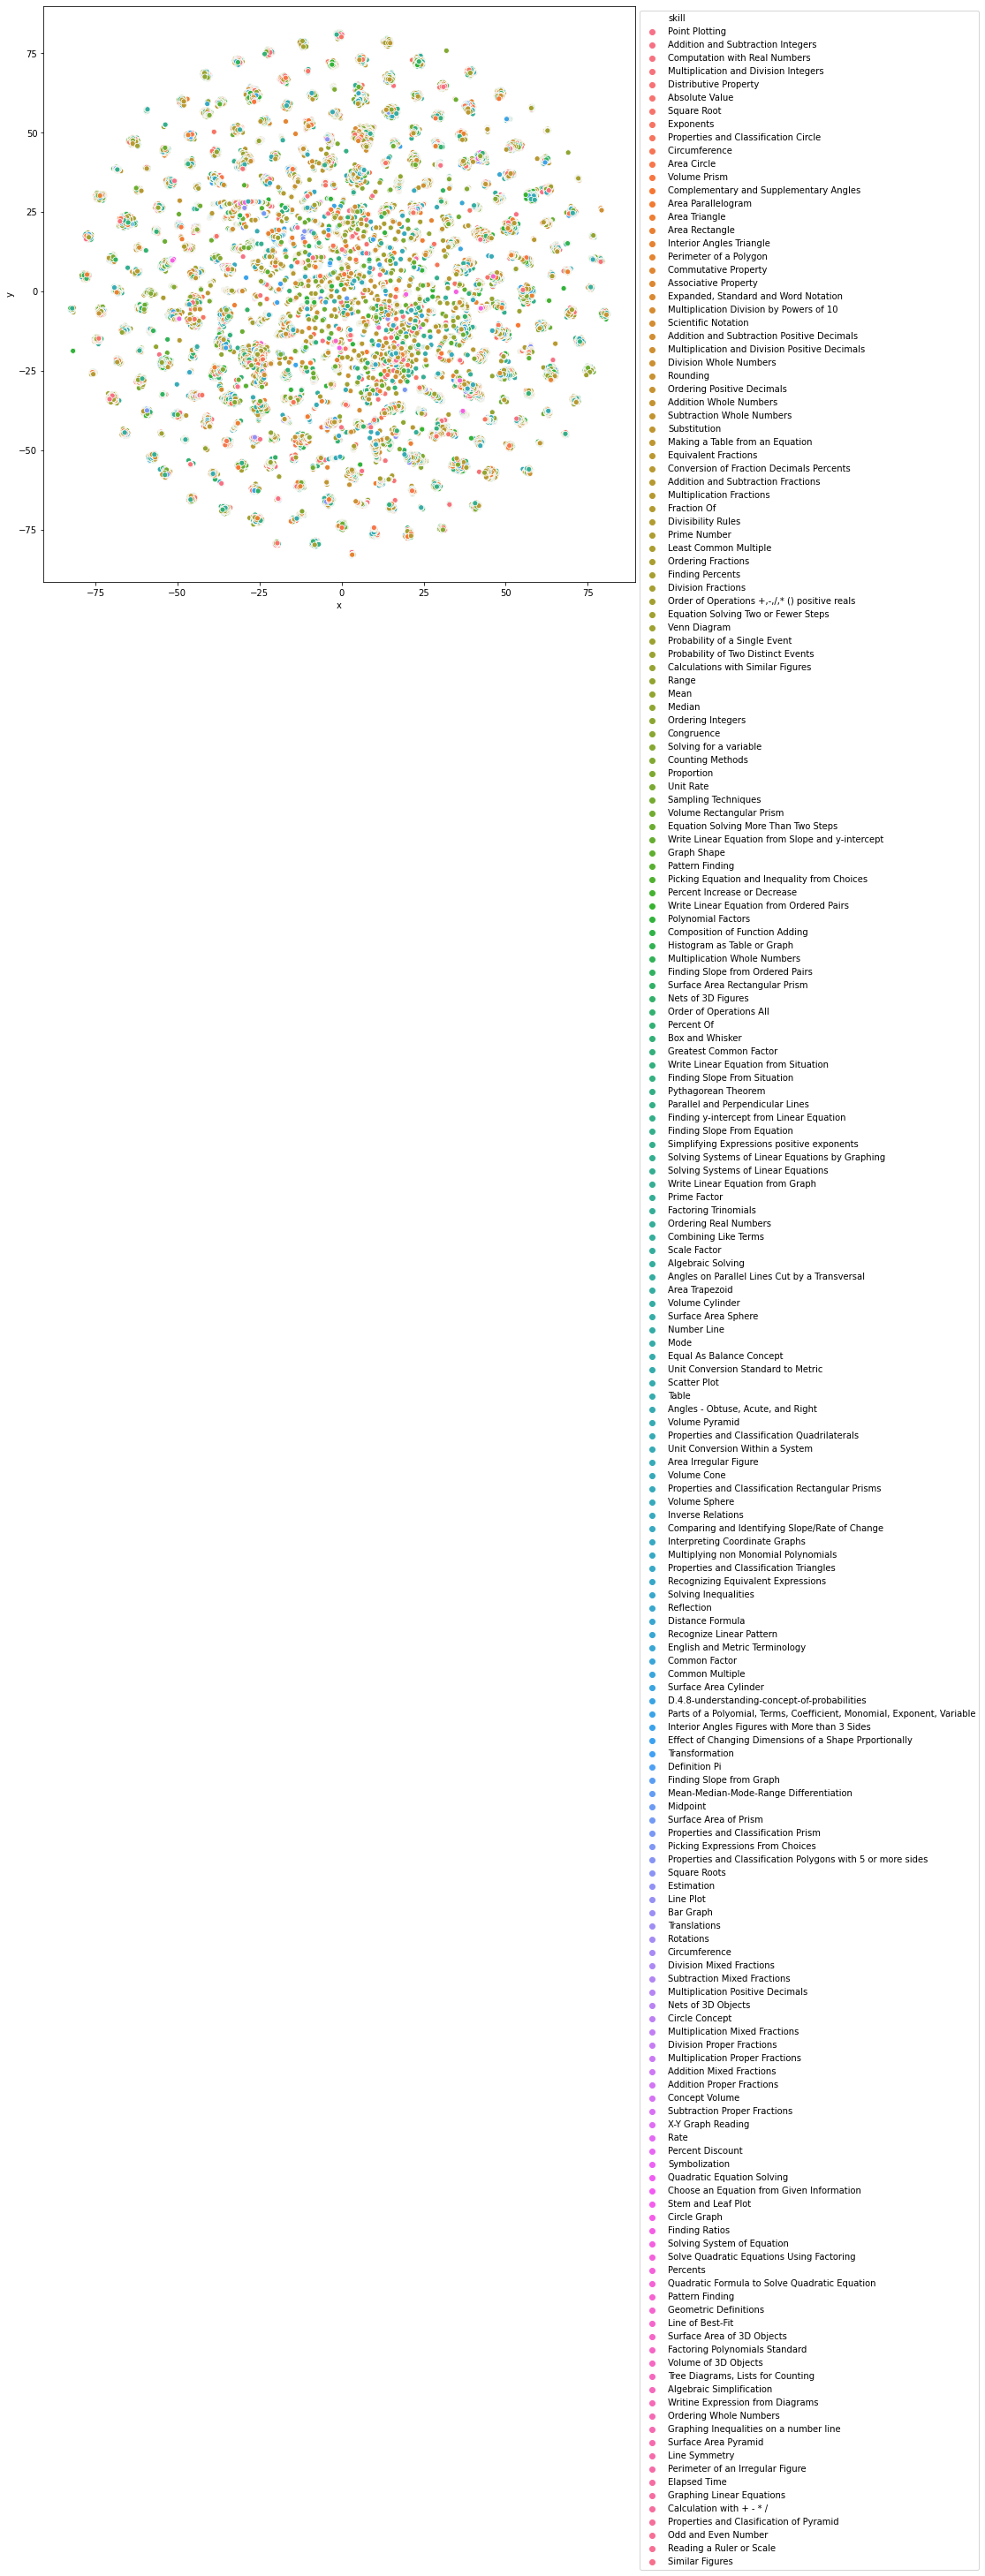

In [0]:
#visualization
plt.figure(figsize=(12,12))
sns.scatterplot(x='x', y='y', hue='skill', data=data)
plt.legend(loc='upper left', bbox_to_anchor=(1,1));

Too many skills! Try to plot a subset of all skills:

In [0]:
top_skill_count = 5
freq_skills = data.groupby('skill').count().sort_values(by='x', ascending=False).index[:top_skill_count].tolist()

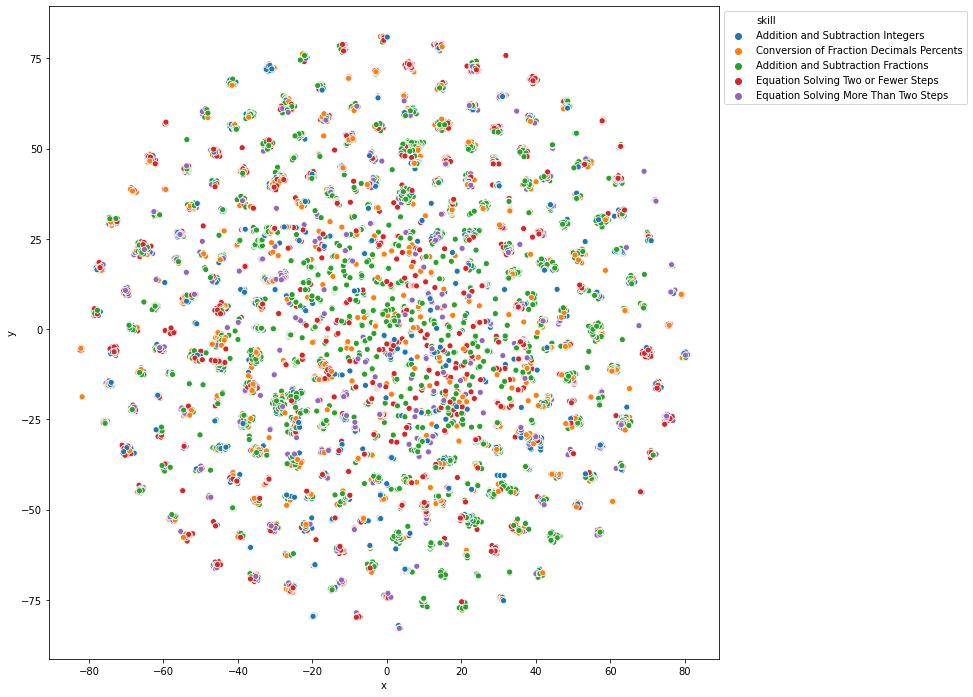

In [0]:
plt.figure(figsize=(12,12))
sns.scatterplot(x='x', y='y', hue='skill', data=data[data.skill.isin(freq_skills)])
plt.legend(loc='upper left', bbox_to_anchor=(1,1));

In [0]:
#generate d3-scatterplot tsv
data.to_csv('viz.tsv', sep='\t', index=False)

3.What do you make of the structure of the visualization? Are problems clustered by skill? Can you make sense of any outliers where the problem is clustered with a different skill cluster from its own.

This visualization structure is the result of dimensionality reduction by TSNE. We used TSNE to project the data onto the 2 demensional plane. Meanwhile, we colored each point by its skill. 
From the result, we can see that the problems are grouped into many small subsets, and many of the small subsets seem to have a dominant skill, although there might be other skills. But the result is not clear enough, we cannot make a precise conclusion.